In [ ]:
import torch
import torchvision

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np 
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.optim as optim


In [4]:
#Permet de tranformer les images en Tenseur pytorch pour un manipulation plus facile
transform = transforms.Compose(
    [transforms.ToTensor(),]
    )
# Permet de charger le dataset CIFAR10
train_dataset = torchvision.datasets.CIFAR10(root= "dataset", transform=transform,train = True, download = True)
test_dataset = torchvision.datasets.CIFAR10(root= "dataset", transform=transform,train = False, download = True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
def imshow(img,class_id):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(classes[class_id])
    plt.axis('off')
    plt.show()

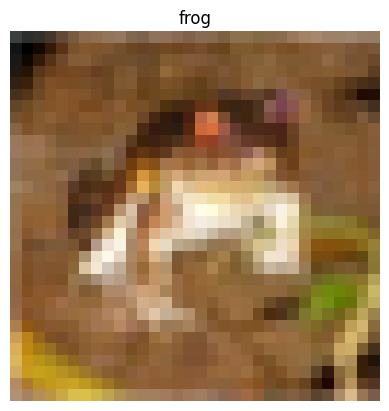

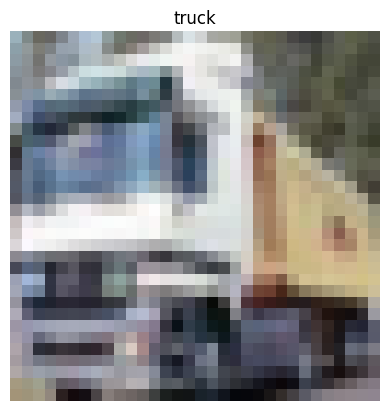

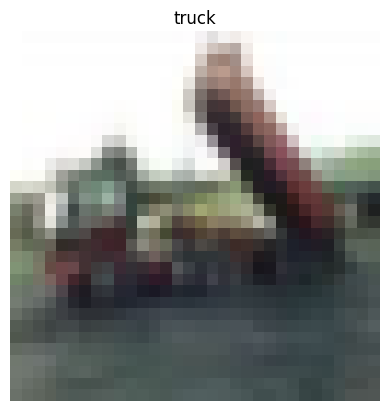

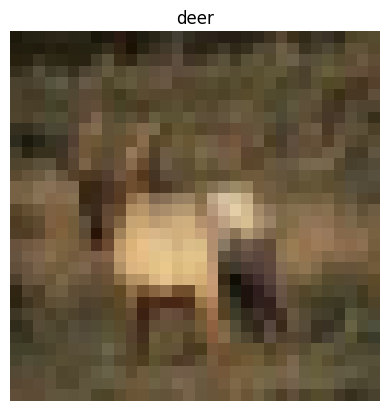

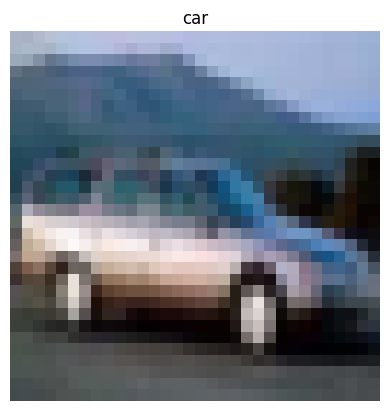

In [4]:
for i, data in enumerate(train_dataset):
    imshow(*data)
    if i == 4:
        break

In [5]:
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# pour dl les id, je l'ai fait a la main

In [5]:

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image

Test avec un réseau pretrained sur imagenet

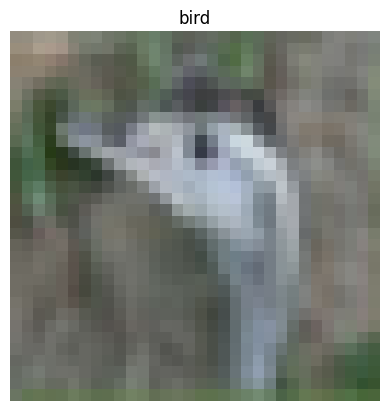

stone wall 0.11615218222141266
ibex 0.03962043300271034
bighorn 0.03210565447807312
lynx 0.027457021176815033
valley 0.016252752393484116


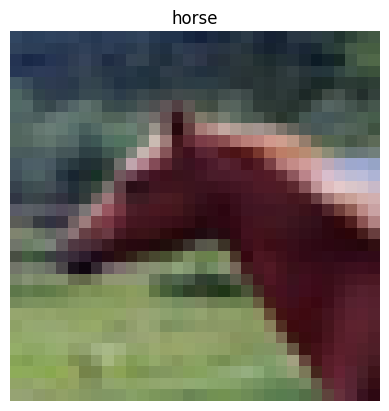

plow 0.17773935198783875
hummingbird 0.03936732932925224
European gallinule 0.03182883933186531
American chameleon 0.026269325986504555
spoonbill 0.025555245578289032


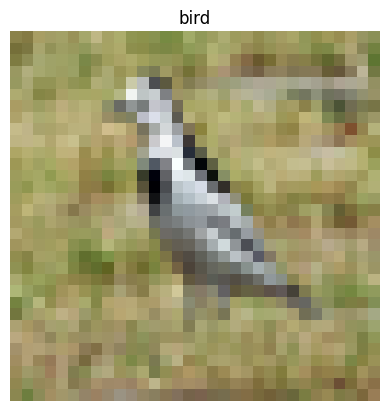

gazelle 0.20898130536079407
impala 0.08295058459043503
wallaby 0.05716642737388611
bustard 0.04609169811010361
quail 0.030099980533123016


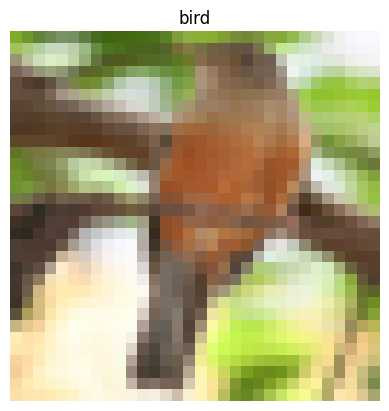

pineapple 0.07773858308792114
common iguana 0.07134434580802917
greenhouse 0.05622633174061775
African chameleon 0.04334138333797455
green lizard 0.03833858296275139


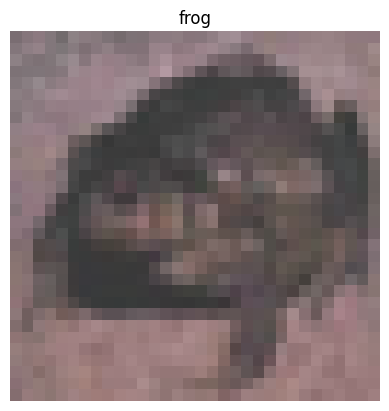

Gila monster 0.09541705250740051
boa constrictor 0.06506039947271347
sidewinder 0.06006685644388199
diamondback 0.05427944287657738
hognose snake 0.0522078238427639


In [7]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=2)
pretrained_network = torchvision.models.resnet18(weights='IMAGENET1K_V1')
imgnet_norm=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

pretrained_network.eval()
for i, data in enumerate(test_loader):
    images, labels = data
    norm_images = imgnet_norm(images)  # Normalize images for pretrained model
    outputs = pretrained_network(norm_images)
    for j in range(5):
        probabilities = torch.nn.functional.softmax(outputs[j], dim=0)
        imshow(images[j], labels[j].item())
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        for i in range(top5_prob.size(0)):
            print(categories[top5_catid[i]], top5_prob[i].item())
    break

On voit que ça ne marche, sans doute pas a cause des images trop petites

On va maintenant entraîner un modèle sur CIFAR10

In [6]:



class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [9]:
batch_size = 4
train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset_splited, val_dataset_splited = random_split(train_dataset, [train_len, val_len])
trainloader =DataLoader(train_dataset_splited, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset_splited, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
print(f"Train dataset size: {len(train_dataset_splited)}")
print(f"Validation dataset size: {len(val_dataset_splited)}")
# Training the network
print(f'Total training dataset size: {len(train_dataset)}')


Train dataset size: 45000
Validation dataset size: 5000
Total training dataset size: 50000


In [ ]:
def train(net, model_name):
    os.makedirs(model_name, exist_ok=True)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_epoch = -1

    num_epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        net.train()

        running_loss = 0.0
        mini_batch_loos = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            mini_batch_loos += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {mini_batch_loos / 2000:.3f}')
                running_loss += mini_batch_loos
                mini_batch_loos = 0.0
        epoch_train_loss = running_loss / len(trainloader)
        train_losses.append(epoch_train_loss)
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        epoch_val_loss = val_loss / len(valloader)
        val_losses.append(epoch_val_loss)
        print(f'Validation loss after epoch {epoch + 1}: {val_loss / len(valloader):.3f}')
        print(f'Running loss after epoch {epoch + 1}: {running_loss / len(trainloader):.3f}')
        # Sauvegarde du modèle
        torch.save(net.state_dict(), f'{model_name}/model_epoch_{epoch+1}.pth')

        # Mise à jour si meilleure loss de validation
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch + 1  # epochs commencent à 1
        

    # Affichage final
    print(f"Best Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch}")

    # Tu peux aussi tracer ici les courbes si tu veux
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train & Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return best_epoch

    





In [10]:
testloader = DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
def test(net, model_name, best_epoch):
    # Chargement du modèle correspondant à l'époque la plus performante
    checkpoint_path = f"{model_name}/model_epoch_{best_epoch}.pth"
    net.load_state_dict(torch.load(checkpoint_path))
    net.eval()  # s'assurer que le modèle est en mode évaluation
    print(f"→ Modèle chargé depuis {checkpoint_path}")

    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')

    # Statistiques par classe
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

[1,  2000] loss: 2.279
[1,  4000] loss: 2.073
[1,  6000] loss: 1.967
[1,  8000] loss: 1.881
[1, 10000] loss: 1.752
Validation loss after epoch 1: 1.644
Running loss after epoch 1: 0.187
[2,  2000] loss: 1.610
[2,  4000] loss: 1.584
[2,  6000] loss: 1.531
[2,  8000] loss: 1.495
[2, 10000] loss: 1.482


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001C357059120>
Traceback (most recent call last):
  File "c:\Programmation\Projets\Capsule\venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "c:\Programmation\Projets\Capsule\venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Validation loss after epoch 2: 1.446
Running loss after epoch 2: 0.163
Best Validation Loss: 1.4460 at Epoch 2


ValueError: x and y must have same first dimension, but have shapes (5,) and (2,)

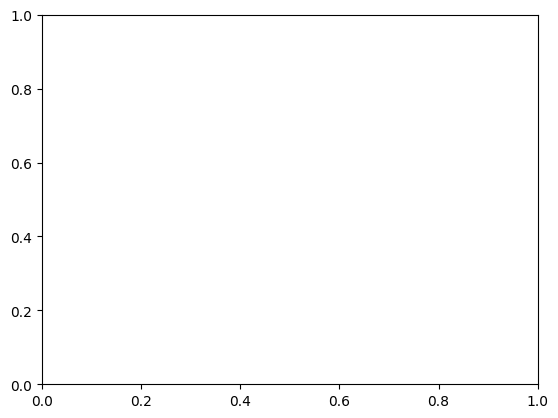

In [34]:
net = Net()
id = train(net,"basic")
print("Training completed, best epoch:", id)
test(net, "basic", id)

In [ ]:
model = torchvision.models.resnet18()
id = train(model, "resnet18")
print("Training completed, best epoch:", id)

test(net, "resnet18", id)


In [ ]:
pretrained_network = torchvision.models.resnet18(weights='IMAGENET1K_V1')
id = train(pretrained_network, "resnet18_pretrained")
print("Training completed, best epoch:", id)

test(pretrained_network, "resnet18_pretrained", id)